Código proyecto semestral

Importamos los módulos necesarios

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

Definimos las condiciones inciales

In [35]:
T_0 = 293.15 #K (es la que aparece en el paper como temperatura inicial utilizada para la simulación)
T_suelo = 285 #K (al ojo, hay que cambiarlo)

Ahora definimos los parametros físicos 

In [56]:
k = 0.13 # W / mK conductividad térmica del maíz (del paper)
rho = 760 # Kg / m^3 densidad del maíz (está como bulk density en el paper)
C_p = 1780 # kJ / Kg K calor especifico del maíz (del paper)
rho_b = 1 #No se que es este parametro pero Camilo lo tenia anotado para la generación de calor
q_tasa = 1 # Es la tasa de generación de calor, no se cuanto es el valor
Q_10 = 1 # No lo encontre en el paper
T_aire = 300 #K (al ojo, creo que esta es la temperatura para la que queremos ajustar la curva para variarla con el tiempo)
epsilon = 0.28 #En el paper esta la del acero y la del cielo, así que asumo que tenemos que usar la del acero
sigma = 5.670374419 * (10**-8) #Constante de Stefan-Boltzmann en W/m^2K^4
h_s = 15 #Coeficiente de transferencia de calor por convección en W/m^2K (Use el que esta en la tabla 4 del paper)
v_z = 1/60000 # m / s Velocidad del aire en el silo ( Totalmente inventado, puse 1 por poner un numero, vamos a tener que cambiarlo)


Como tanto para el termino de generación como para el de perdida de calor existen factores no lineales, para la matriz de coeficientes A vamos a utilizar unicamente los coefcientes de los terminos de adveccción y difusión mientras que la generación y la perdida formaran parte del vector b.

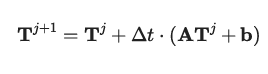

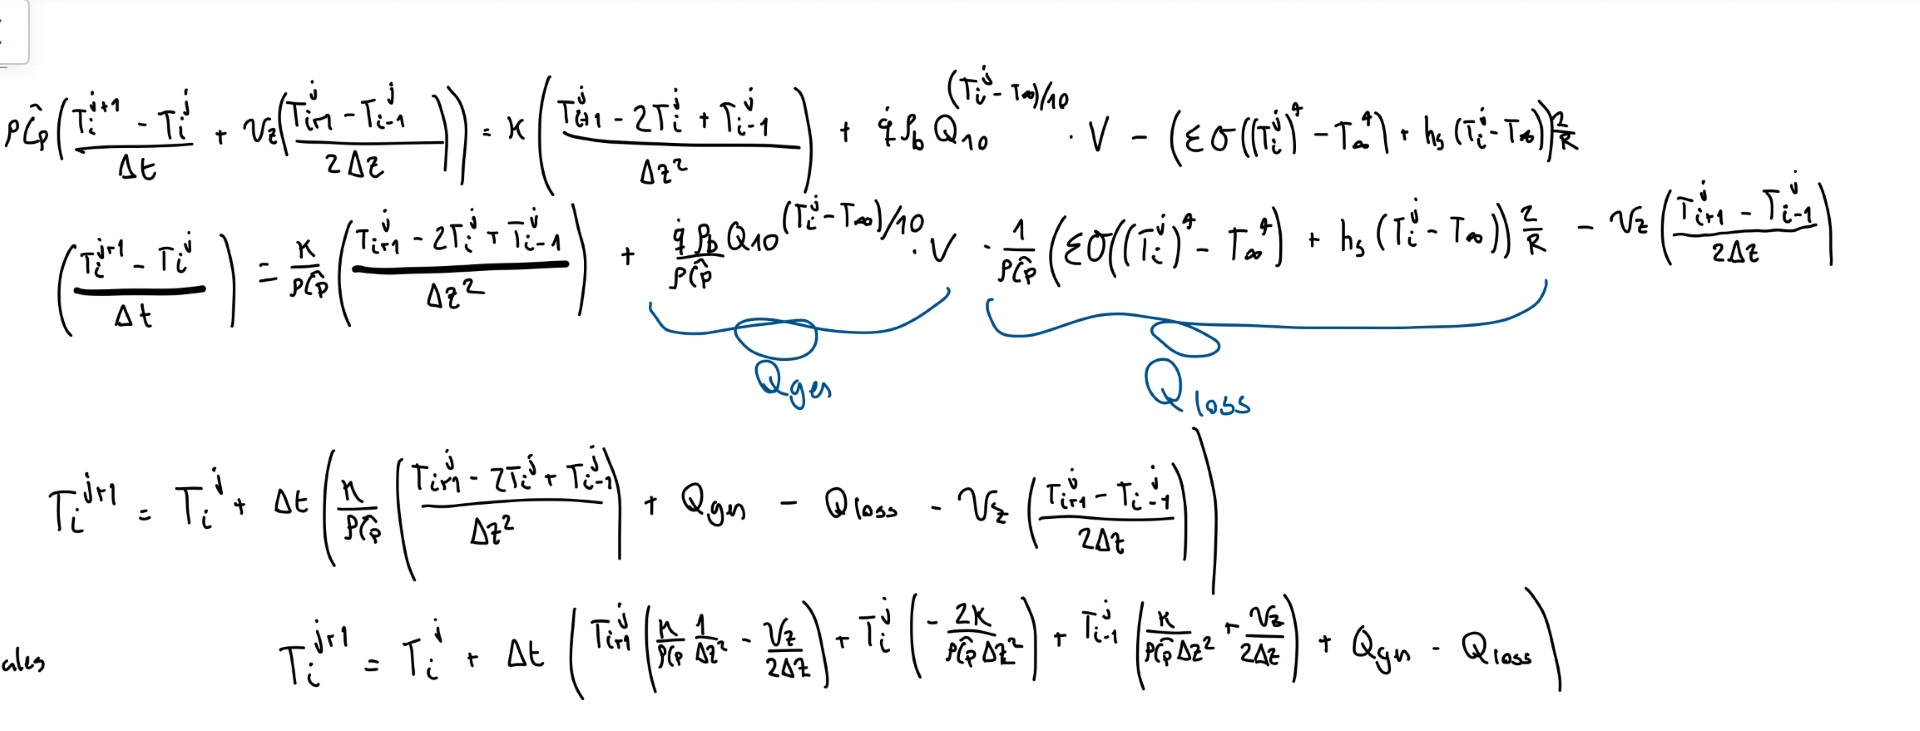

La segunda imagen es el desarrollo que hice, despues hay que pasarla a limpio.

A continuación definimos los parámetros de tamaño para el primer silo a analizar

In [37]:
L = 10 #m (largo del silo)
R = 1 #m (radio del silo)
V_1 = np.pi * R**2 * L #m^3 (volumen del silo)

Ahora definimos los parámetros de la simulación

In [38]:
# Número de nodos en la dirección z (100 nodos por ejemplo, podemos cambiarlo después)
n_z = 101   #Acá hay que fundamentar bien porque son 101, yo copie lo que hacia en el MOOC nomas

# Espaciamiento de tiempo (hay que pensar bien cuanto tiempo queremos simular, por mientras voy a utilizar 24 horas con pasos de 10 minutos)
dt = 600 # segundos

z = np.linspace(0, L , n_z + 1)
dz = L/(n_z-1)

# Condiciones iniciales
# Temperatura inicial a lo largo del silo
T = np.ones(n_z + 1) * T_0  # Acá es donde tenemos que hacer lo de ajustar la curva creo

# Tiempo inicial y tiempo final
t_0 = 0 # segundos
t_f = 24 * 3600 # segundos

Ahora generamos la matriz de coeficientes A y el vector b

In [39]:
A = np.zeros((n_z + 1, n_z + 1))

for i in range(1, n_z):
    A[i, i-1] = k/(rho * C_p * dz**2) + v_z/(2 * dz)
    A[i, i] = -2*k/(rho * C_p * dz**2)
    A[i, i+1] = k/(rho * C_p * dz**2) - v_z/(2 * dz)

b = np.ones(len(T)) * (q_tasa * rho_b * V_1/(rho * C_p) * (Q_10**((T - T_aire)/10)) - 2/(rho * C_p* R) * (epsilon * sigma * (T**4 - T_aire**4) + h_s * (T - T_aire)))

Ahora anotamos las condciones de borde ( la foto es por mientras, hay que pasarla a limpio)
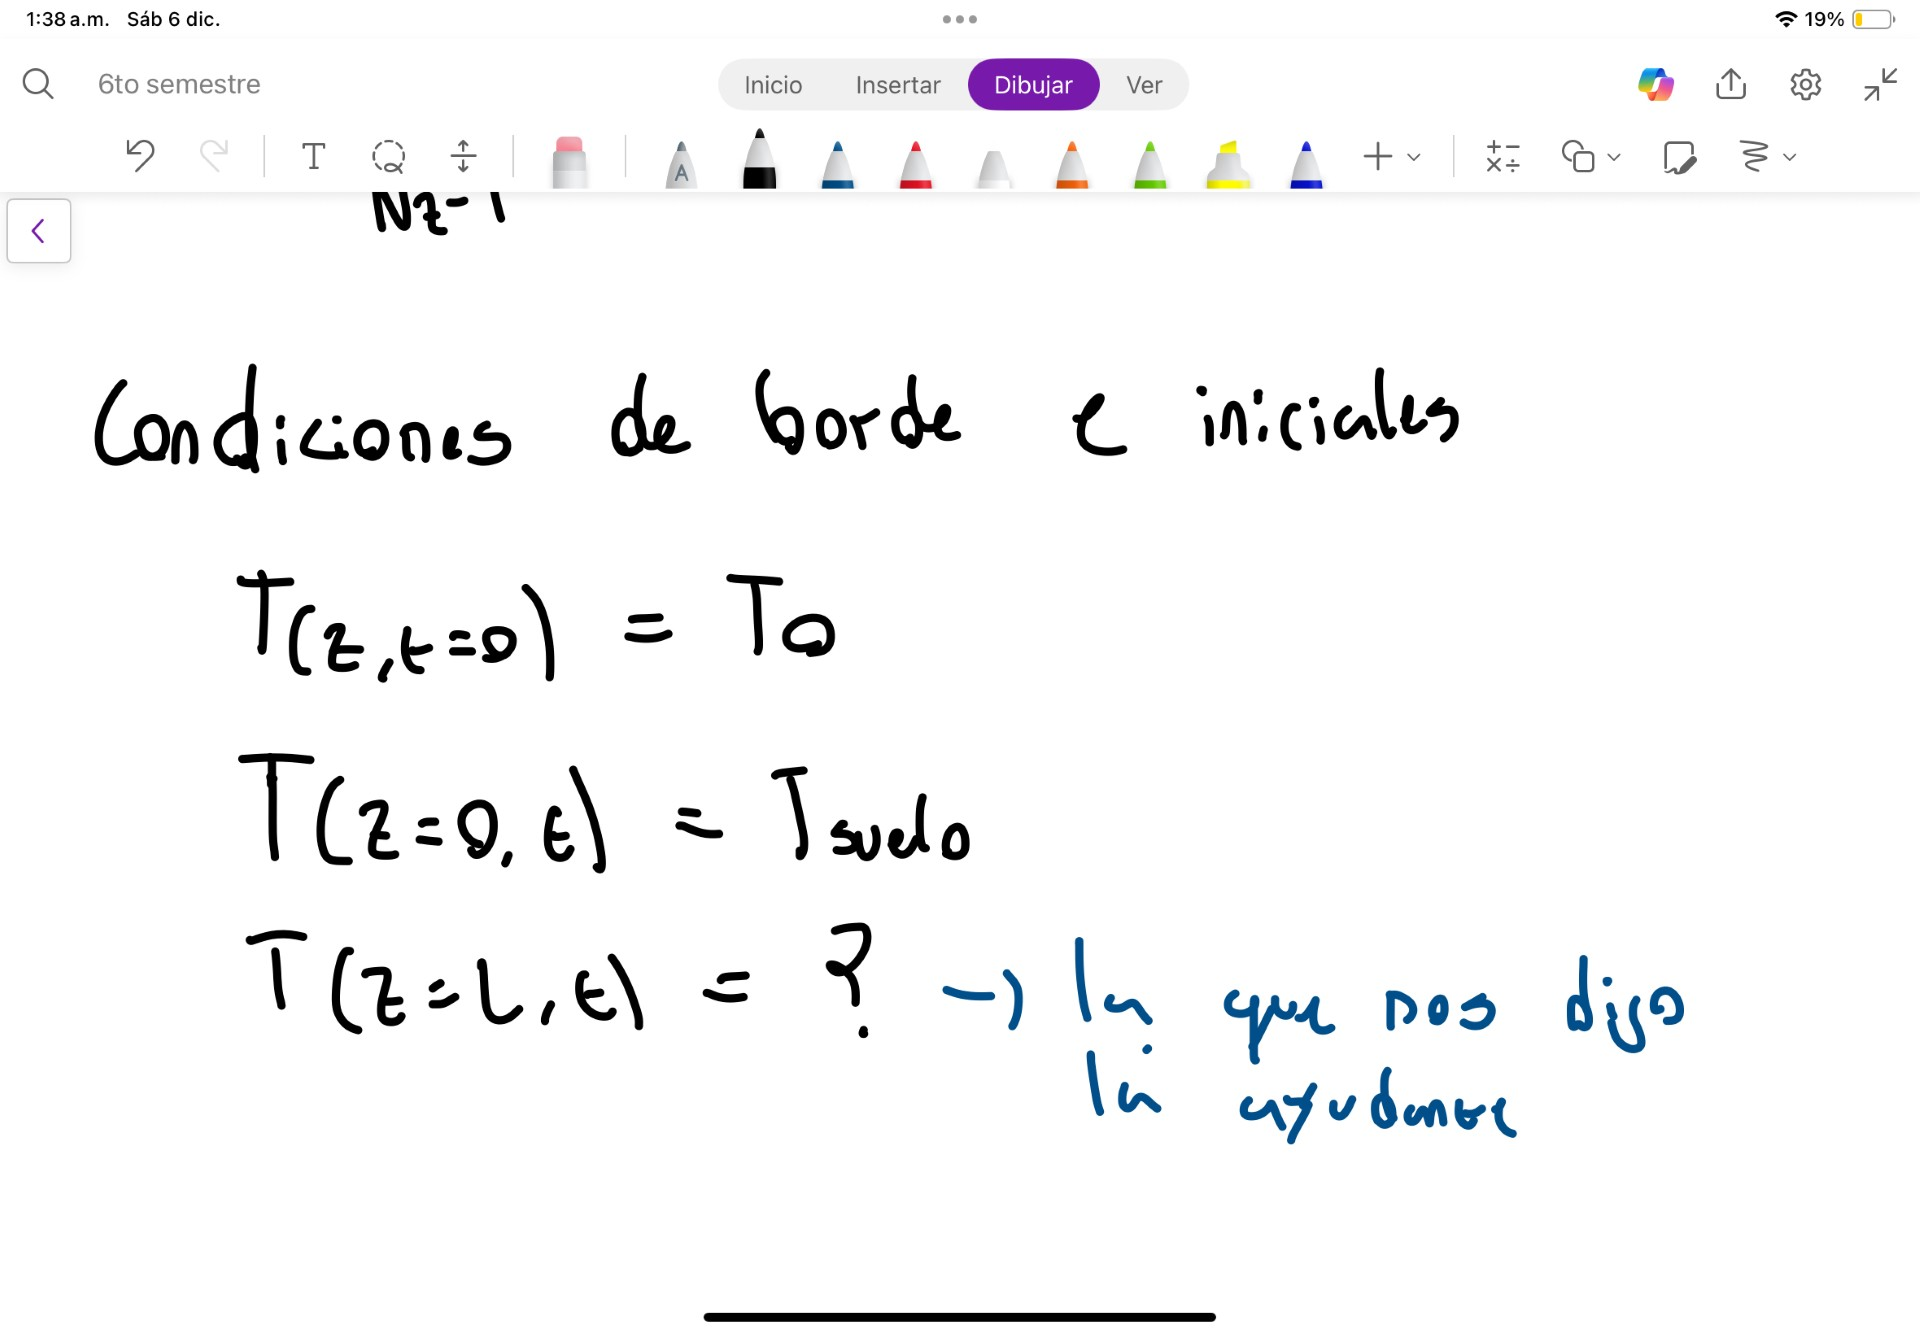

In [40]:
# Condición de frontera en z = 0 (suelo)
A[0,0] = 0
b[0] = 0

In [41]:
# Condición de frontera en z = L (parte superior del silo)
#Acá tenemos que usar la condición de borde que nos habia dicho la ayudante, si no nos motivamos podemos poner que sea la temperatura del aire nomas (eso voy a usar por mientras)
A[-1, -1] = 0
b[-1] = 0

Ahora realizamos una iteración

In [42]:
T_new = T + dt * (np.dot(A, T) + b)
T_new # Se va a ver rarisimo porque hay varios parametros mal definidos y no hemos hecho el ajsute de la curva de temperatura ambiente

array([293.15      , 293.26514571, 293.26514571, 293.26514571,
       293.26514571, 293.26514571, 293.26514571, 293.26514571,
       293.26514571, 293.26514571, 293.26514571, 293.26514571,
       293.26514571, 293.26514571, 293.26514571, 293.26514571,
       293.26514571, 293.26514571, 293.26514571, 293.26514571,
       293.26514571, 293.26514571, 293.26514571, 293.26514571,
       293.26514571, 293.26514571, 293.26514571, 293.26514571,
       293.26514571, 293.26514571, 293.26514571, 293.26514571,
       293.26514571, 293.26514571, 293.26514571, 293.26514571,
       293.26514571, 293.26514571, 293.26514571, 293.26514571,
       293.26514571, 293.26514571, 293.26514571, 293.26514571,
       293.26514571, 293.26514571, 293.26514571, 293.26514571,
       293.26514571, 293.26514571, 293.26514571, 293.26514571,
       293.26514571, 293.26514571, 293.26514571, 293.26514571,
       293.26514571, 293.26514571, 293.26514571, 293.26514571,
       293.26514571, 293.26514571, 293.26514571, 293.26

Ahora hacemos las iteraiones

In [57]:
write_interval = 600

t_vec = []  # Vector para almacenar los tiempos

T_old = np.copy(T) # Copia de la temperatura inicial

T_num = [] # Lista para almacenar las temperaturas en cada paso de tiempo

while t_0 < t_f:
    b = (q_tasa * rho_b * V_1/(rho * C_p) * (Q_10**((T_old - T_aire)/10)) - 2/(rho * C_p* R) * (epsilon * sigma * (T_old**4 - T_aire**4) + h_s * (T_old - T_aire)))
    T_new = T_old + dt * (np.dot(A, T_old) + b)

    b[0] = 0
    b[-1] = 0

    T_new[0] = T_suelo  # Condición de frontera en z = 0 (suelo)
    T_new[-1] = T_aire  # Condición de frontera en z = L (parte superior del silo)
    t_0 += dt
    T_old = np.copy(T_new)



    if t_0%write_interval < 0.9*dt:
        T_num.append(T_new)  # Almacenar la temperatura en cada paso de tiempo
        t_vec.append(t_0)  # Almacenar el tiempo correspondiente


# esta celda esta muy sospechosa, la copie entera del MOOC sin entender muy bien que estaba haciendo y me faltaron un par de lineas de código que no supe que hacer.

C:\Users\mozol\AppData\Local\Temp\ipykernel_9444\2742306214.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cividis = cm.get_cmap("cividis", n_temp)
C:\Users\mozol\AppData\Local\Temp\ipykernel_9444\2742306214.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


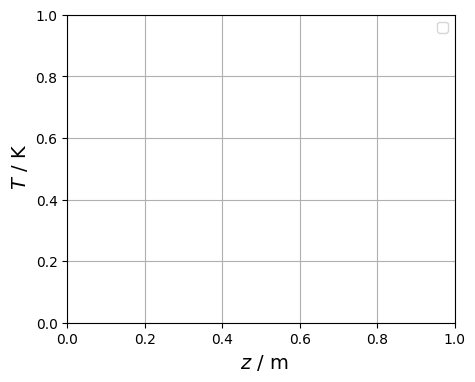

In [58]:
fig, ax = plt.subplots(1, 1, figsize = [5,4])
# Número de perfiles de temperatura totales a graficar
n_temp = len(T_num)
# Utilizar paleta de colores inclusiva
cividis = cm.get_cmap("cividis", n_temp)
colour = [cividis(i/n_temp) for i in range(n_temp)]
# colours = [cividis(0), cividis(1 / 7), cividis(2 / 7), cividis(3 / 7), cividis(4 / 7), cividis
for k in range(len(T_num)):
    plt.plot(z, T_num[k], color = colour[k], label = "t = %.0f s" % t_vec[k])
plt.xlabel(' $z$ / m', size = 14)
plt.ylabel(' $T$ / K', size = 14)
plt.grid()
plt.legend()
plt.show()